In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import plotly
import plotly.figure_factory as ff
from plotly.offline import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier



pd.set_option('display.max_columns', 300)

In [89]:
demo_features = ['X2SEX', 'X2RACE', 'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION', 'X3TCREDSCI']


mvp_features = ['X2STU30OCC_STEM1', 'X2STUEDEXPCT', 'X2S2SSPR12', 'S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
               'S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2OTHS12SP', 
               'S2HISCIENCE12', 'S2APSCIENCE', 'S2IBSCIENCE', 'S2STOOKBEFORE', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED', 'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL', 'S2APSCIENCE', 'S2HSPLAN', 'S2SUBMITPLAN', 'S2SCLUB', 
            'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED', 'X4RFDGMJ123', 'X4RFDGMJSTEM']

family_features = ['X2PAR1EDU', 'X2PAR1OCC_STEM1', 
            'X2PAR1RACE', 'X2PAR2EDU', 'X2PAR2OCC_STEM1', 'X2PAR2RACE', 'X2PARPATTERN', 
            'X2MOMEDU', 'X2MOMOCC_STEM1', 'X2MOMRACE', 'X2DADEDU', 'X2DADOCC_STEM1', 
            'X2DADRACE']

cols_list = demo_features + mvp_features



In [90]:
df = pd.read_csv('data-files/HSLS/hsls_17_student_pets_sr_v1_0.csv', usecols = cols_list)
df.rename(columns = {'X4RFDGMJSTEM': 'target'}, inplace = True)

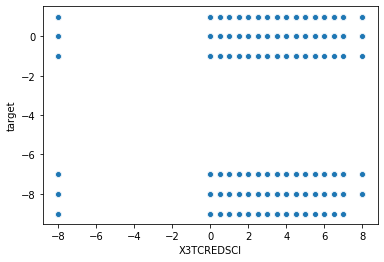

In [94]:
df.X3TCREDSCI.value_counts()



In [8]:
#drop rows with non-response to S2SLEARN (and many other features) (likely dropped from study)
df = df[df['S2SLEARN'] != -8]

#create dummy variables for races
df['ai_an'] = np.where(df['X2RACE'] == 1, 1, 0)
df['asian'] = np.where(df['X2RACE'] == 2, 1, 0)
df['black'] = np.where(df['X2RACE'] == 3, 1, 0)
df['hispanic'] = np.where((df['X2RACE'] == 4) | (df['X2RACE'] == 5), 1, 0)
df['multiple_race'] = np.where(df['X2RACE'] == 6, 1, 0)
df['nh_pi'] = np.where(df['X2RACE'] == 7, 1, 0)
df['white'] = np.where(df['X2RACE'] == 8, 1, 0)


In [9]:
#'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION'

#create dummy for public/private school
df['private'] = [1 if x == 2 else 0 for x in df['X2CONTROL']]
df['public'] = [1 if x == 1 else 0 for x in df['X2CONTROL']]

In [10]:
#compile all subchoices of STEM domains into yes/no
df.X2STU30OCC_STEM1.replace({-9:0, 9:0, 4:1, 5:1, 6:1}, inplace = True)


In [11]:
classes = ['S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2APSCIENCE', 'S2IBSCIENCE']

#impute 'no' for items that are missing or were skipped due to not taking a science class
for col in classes:
    df[col].replace({-9:0, -7:0}, inplace= True)


In [12]:
df.S2SSPR12.value_counts()

1    16192
0     4402
Name: S2SSPR12, dtype: int64

In [13]:
#impute unknown with 'no' for if participating in science activity

clubs_cols = ['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED']

for col in clubs_cols:
    df[col].replace({-9:0}, inplace = True)

In [14]:
df.S2HSPLAN = np.where(df['S2HSPLAN'] == 1, 1, 0)
df.S2SUBMITPLAN = np.where(df['S2SUBMITPLAN'] == 1, 1, 0)

In [15]:
#create class for underrepresented group in STEM (women, black, american indian, hispanic, pacific islander)

df['underrep'] = np.where((df['X2SEX'] == 2) |
                          (df['ai_an'] == 1) |
                          (df['black'] == 1) |
                          (df['hispanic'] == 1) |
                          (df['multiple_race'] == 1) |
                          (df['nh_pi'] == 1), 1, 0)
                         

In [16]:
#group HS science classes into broader subjects

df['bio'] = np.where((df['S2LIFES12'] == 1) |
                      (df['S2BIO1S12'] == 1) |
                      (df['S2BIO2S12'] == 1) |
                      (df['S2APBIOS12'] == 1) |
                      (df['S2IBIOS12'] == 1) |
                     (df['S2ANATOMYS12'] == 1) |
                      (df['S2OTHBIOS12'] == 1), 1, 0)
               

df['chem'] = np.where((df['S2CHEM1S12'] == 1) |
                      (df['S2CHEM2S12'] == 1) |
                      (df['S2APCHEM12'] == 1) |
                      (df['S2IBCHEM12'] == 1), 1, 0)
              

df['enviro'] = np.where((df['S2EARTHS12'] == 1) |
                        (df['S2EARTHS12'] == 1) |
                        (df['S2APENVS12'] == 1) |
                        (df['S2OTHENVS12'] == 1), 1, 0)
                        
df['physics'] = np.where((df['S2PHYSIC1S12'] == 1) |
                         (df['S2PHYSIC2S12'] == 1) |
                         (df['S2APPHYSIC12'] == 1) |
                         (df['S2IBPHYSIC12'] == 1) |
                         (df['S2PHYSS12'] == 1), 1, 0)
                         
df['engineering'] = np.where((df['S2ENGINEER12'] == 1), 1, 0)


df['compsci'] = np.where((df['S2COMPAPP12'] == 1) |
                         (df['S2COMPPROG12'] == 1) |
                         (df['S2APCOMPSCI12'] == 1) |
                         (df['S2IBTECH12'] == 1) |
                         (df['S2OTHCOMP12'] == 1), 1, 0)

df['misc_class'] = np.where((df['S2OTHPHYS12'] == 1) |
                            (df['S2INTGS1S12'] == 1) |
                            (df['S2GENS12'] == 1), 1, 0)


In [17]:
#create column for students who took science earlier in the year (but don't now)
df['took_science_2012'] = np.where((df['S2STOOKBEFORE'] == 1) |
                                   (df['bio'] == 1) |
                                   (df['chem'] == 1) |
                                   (df['enviro'] == 1) |
                                   (df['physics'] == 1) |
                                   (df['engineering'] == 1) |
                                   (df['compsci'] == 1) |
                                   (df['misc_class'] == 1), 1, 0)


In [18]:
df.took_science_2012.value_counts()

1    18051
0     2543
Name: took_science_2012, dtype: int64

In [19]:
#impute 'no' for items that are missing or were skipped due to not taking a science class

why_science = ['S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED']

for col in why_science:
    df[col].replace({-9:0, -7:0}, inplace= True)

In [96]:
#create dataframe with target variable
modeling_df = df[(df.target == 0) | (df.target == 1)]



In [21]:
likert_cols = ['S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
                'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL']

#change likert questions to agree/disagree
for col in likert_cols:
   modeling_df[col].replace({2:1, 3:0, 4:0, -9:0, }, inplace = True)

In [82]:
modeling_df.underrep.value_counts(normalize = True)

1    0.685165
0    0.314835
Name: underrep, dtype: float64

In [50]:
modeling_df.groupby(by = ['target'])['underrep'].value_counts(normalize = True)

target  underrep
0       1           0.732478
        0           0.267522
1       1           0.529343
        0           0.470657
Name: underrep, dtype: float64

In [24]:
modeling_df.underrep.value_counts(normalize = False)

1    7519
0    3455
Name: underrep, dtype: int64

In [58]:
x = ['one', 'two', 'three', 'four']

modeling_df.target.value_counts().index
modeling_df.target.value_counts(normalize = True)

0    0.767086
1    0.232914
Name: target, dtype: float64

In [80]:
grouped = modeling_df.groupby(by = ['target'])['underrep'].value_counts(normalize = True)
#sns.barplot(y = grouped, x=['l', 'm', 'n', 'o'])
grouped
#modeling_df.groupby['X2RACE'].value_counts(normalize = True)

target  underrep
0       1           0.732478
        0           0.267522
1       1           0.529343
        0           0.470657
Name: underrep, dtype: float64

TypeError: 'int' object is not iterable